In [2]:
import os
import re
from PIL import Image
import torch
from tqdm.auto import tqdm
import numpy as np
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.pc_to_mesh import marching_cubes_mesh
from point_e.util.mesh import TriMesh

c:\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load base models

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('loading base model...')
base_name = 'base1B' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

# downloading upsampler checkpoint
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

loading base model...
creating upsample model...
downloading base checkpoint...


<All keys matched successfully>

### Load model for mesh

In [4]:
print('loading SDF model...')
sdf_model = model_from_config(MODEL_CONFIGS['sdf'], device)
sdf_model.eval()

sdf_model.load_state_dict(load_checkpoint('sdf', device))

loading SDF model...


<All keys matched successfully>

In [5]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

### Generate meshes

In [ ]:
directory = "homes_data/all_homes_images"
all_images = []
all_images_names = []
for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    name_only = re.split('\.jpg\s*', filename)[0]
    if os.path.isfile(f):
        all_images_names.append(name_only)
        all_images.append(Image.open(f))   

In [22]:
# Produce a meshes and pointclouds from the model.
pointclouds = []
meshes = {}
for index in range(len(all_images)):
    samples = None
    for sample_tensor in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[all_images[index]]))):
        samples = sample_tensor
    
    # Output pointcloud and convert to meshes.
    pointcloud = sampler.output_to_point_clouds(samples)[0]
    pointclouds.append(pointcloud)
    meshes[all_images_names[index]] = marching_cubes_mesh(
        pc=pointcloud,
        model=sdf_model,
        batch_size=4096,
        grid_size=32, # increase to 128 for resolution used in evals
        progress=True,
    )


130it [1:49:07, 50.36s/it]
100%|██████████| 8/8 [00:10<00:00,  1.28s/it]
130it [1:45:34, 48.73s/it]
100%|██████████| 8/8 [00:10<00:00,  1.34s/it]
130it [1:45:01, 48.47s/it]
100%|██████████| 8/8 [00:09<00:00,  1.21s/it]
130it [1:44:28, 48.22s/it]
100%|██████████| 8/8 [00:10<00:00,  1.27s/it]


### Save OBJs using meshes

In [ ]:
obj_directory = "homes_data/all_homes_obj"

for index in range(len(meshes)):
    mesh = meshes[all_images_names[index]]
    full_path = obj_directory + "/" + all_images_names[index] + ".obj"
    f = open(full_path, "w")
    for i in range(len(mesh.verts)):
        f.write("v " + str(mesh.verts[i][0]) + " " + str(mesh.verts[i][1]) + " " + str(mesh.verts[i][2]) + " ")
        f.write("\n")

    for i in range(len(mesh.normals)):
        f.write("vn " + str(mesh.normals[i][0]) + " " + str(mesh.normals[i][1]) + " " + str(mesh.normals[i][2]) + " ")
        f.write("\n")

    for i in range(len(mesh.faces)):
        f.write("f " + str(mesh.faces[i][0]) + " " + str(mesh.faces[i][1]) + " " + str(mesh.faces[i][2]) + " ")
        f.write("\n")
    f.close()

### Final figures and plots

big-dome
first-dome
simple-dome
small-dome


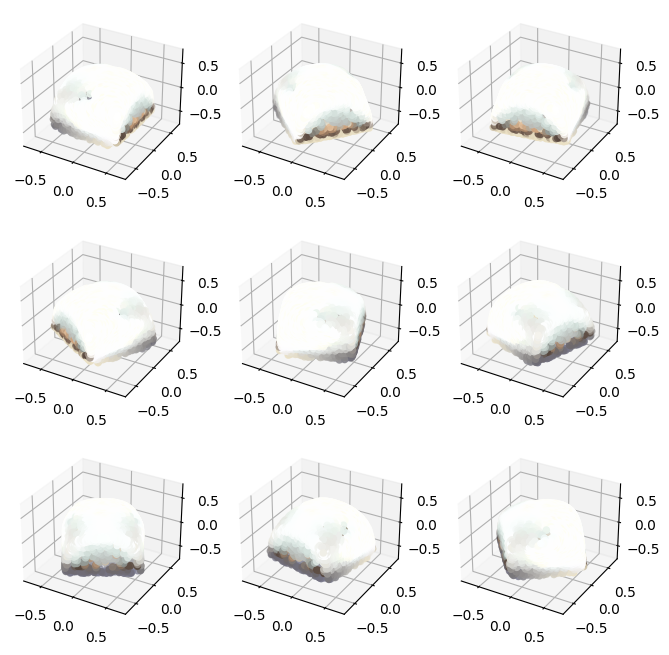

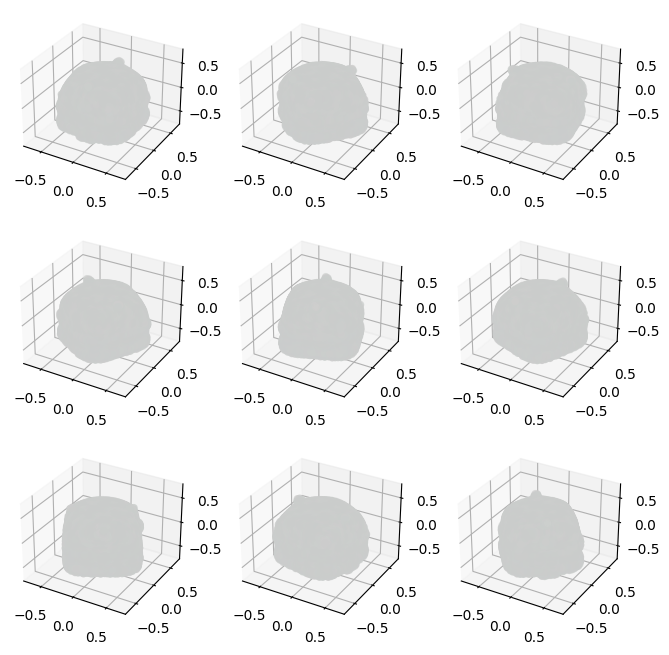

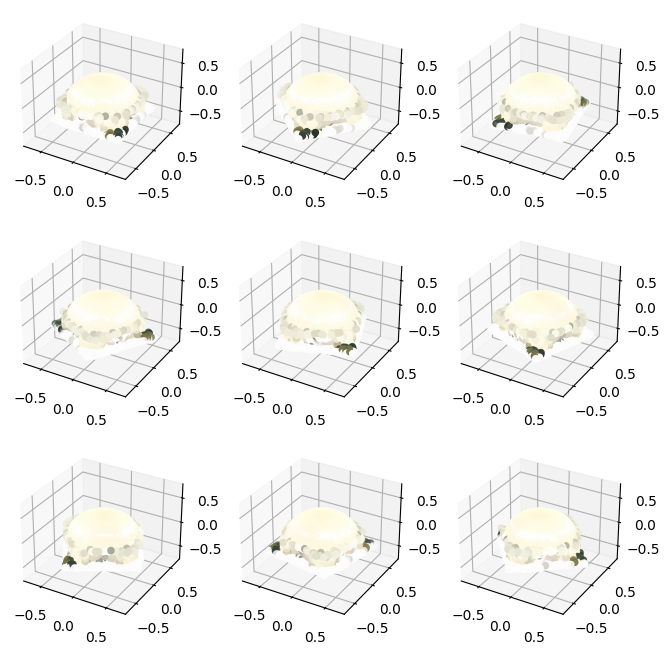

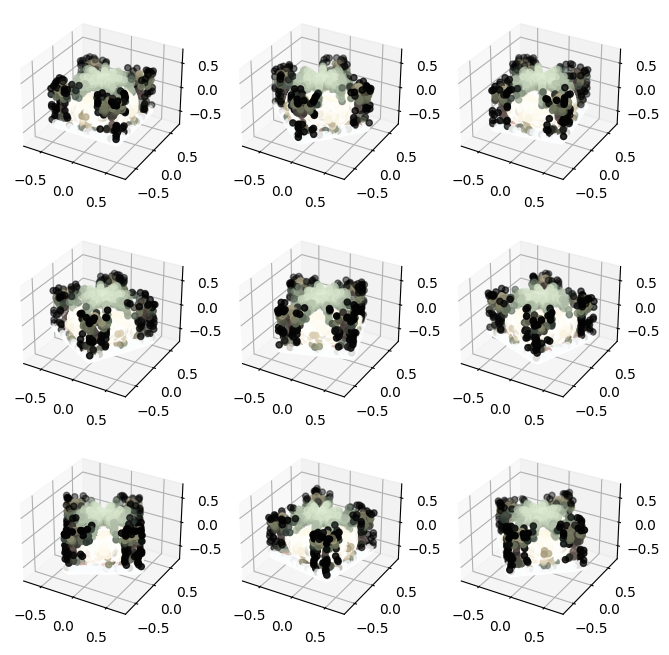

In [25]:
# Log all figures
for index in range(len(pointclouds)):
    print(all_images_names[index])
    fig = plot_point_cloud(pointclouds[index], grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))
